In [1]:
import numpy as np
import torch
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from model.unet import Unet
from model.diffusion import Diffusion_Models
from model.dataset import MyDataset
from train import train
from torchvision.transforms.functional import adjust_saturation

# training hyperparameters
BATCH_SIZE = 32
EPOCHS = 100
LR = 1e-3
# network hyperparameters
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
N_FEAT = 64 # 64 hidden dimension feature
HEIGHT = 128
SAVE_DIR = './weights/'
GEN_DIR = './generated_images/'
# diffusion hyperparameters
TIMESTEPS = 1000

# DataSet path
dataset_path = '../SuperRes/dataset/conceptual_captions_128.npy'

## Entrenamiento

In [ ]:
model = Unet(in_channels=3, n_feat=N_FEAT, height=HEIGHT).to(DEVICE)
#model.load_state_dict(torch.load(SAVE_DIR+"model_color_031.pth", map_location=DEVICE))
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
df = Diffusion_Models(TIMESTEPS)

dataset = MyDataset(dataset_path)
generator1 = torch.Generator().manual_seed(42)
train_dataset, validation_dataset = random_split(dataset, [45007,5000], generator=generator1)

train(model, df, optimizer, train_dataset, validation_dataset, BATCH_SIZE, EPOCHS, DEVICE)

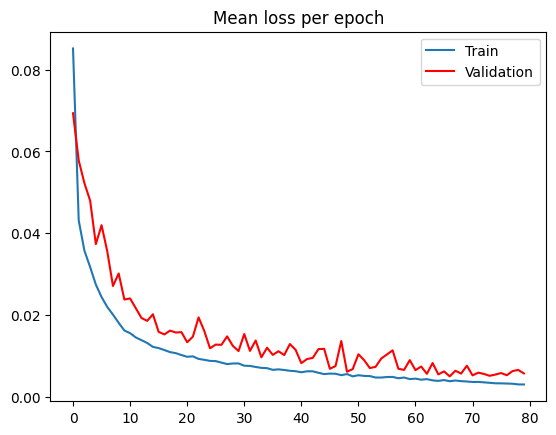

In [2]:
metrics = np.load('./metrics/color.npy', allow_pickle=True).item()
plt.figure()
plt.plot(range(len(metrics['train'])), metrics['train'], label = "Train") 
plt.plot(range(len(metrics['validation'])), metrics['validation'], 'r', label = "Validation") 
plt.title("Mean loss per epoch")
plt.legend() 
plt.show()
plt.close()

## Generación

In [2]:
dataset = MyDataset(dataset_path)
df = Diffusion_Models(TIMESTEPS)
model = Unet(in_channels=3, n_feat=N_FEAT, height=HEIGHT).to(DEVICE)
model.load_state_dict(torch.load(SAVE_DIR+"model_color_036.pth", map_location=DEVICE))
model.eval()

def saturacion(img, sat):
    return adjust_saturation(df.unorm(img.permute(1,2,0)).permute(2,0,1), sat)

def draw_samples(imgs, samples):
    plt.figure(figsize=(len(imgs)*3, 10))
    for i, img in enumerate(imgs):
        img_bw = saturacion(img, 0.1).permute(1,2,0)
        img = img.permute(1,2,0).cpu().numpy()
        plt.subplot(3, len(imgs), i+1)
        plt.imshow(df.unorm(img))
        plt.subplot(3, len(imgs), len(imgs)+i+1)
        plt.imshow(img_bw)
    for i, img in enumerate(samples):
        img = img.permute(1,2,0).cpu().numpy()
        plt.subplot(3, len(imgs), 2*len(imgs)+i+1)
        plt.imshow(df.unorm(img))

c:\Users\david\OneDrive - Universidad Complutense de Madrid (UCM)\Escritorio\Git\TFG-DiffusionModels\ColorPalette\model\diffusion.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img)


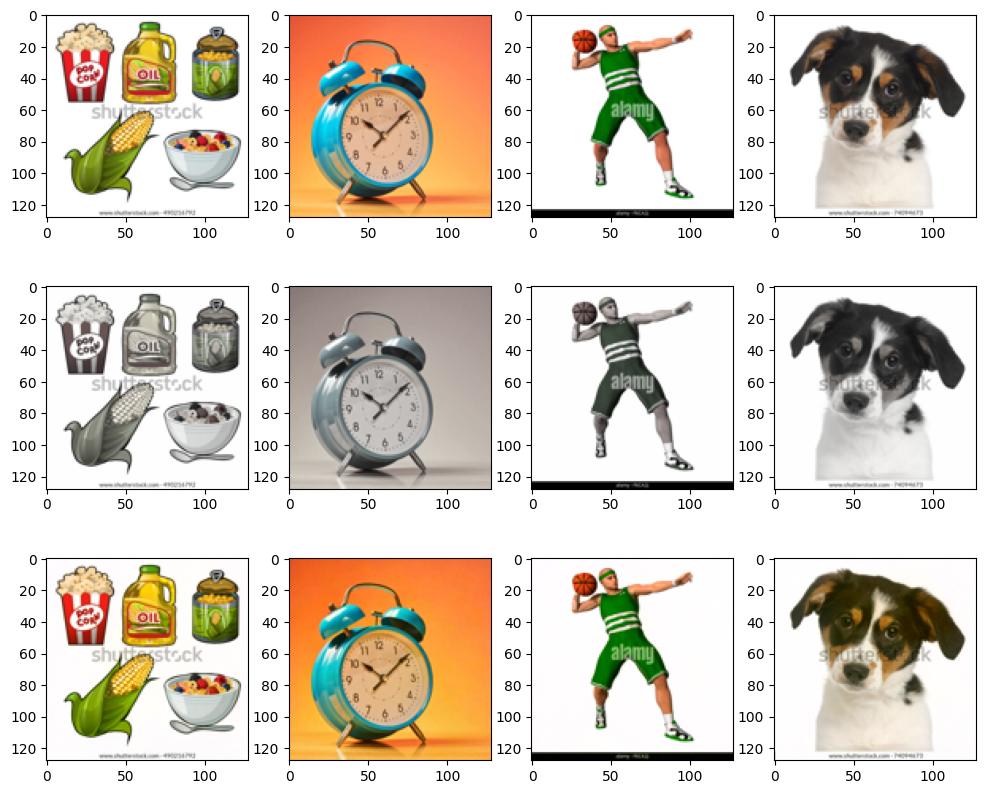

In [5]:
imgs = [dataset[10], dataset[20], dataset[70], dataset[150]]
imgs_low = [saturacion(x, 0.1) for x in imgs]
samples = df.sample_ddpm_context(model, len(imgs), imgs_low, end_timestep=TIMESTEPS).cpu()

draw_samples(imgs, samples)